# 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

아래와 같이 다운로드를 진행해 주세요.

wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt  
wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt  
mv ratings_*.txt ~/aiffel/sentiment_classification  

## 데이터 준비하기 & 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


# 모델구성 및 validation set 구성

### Conv1D layer를 활용한 model

In [7]:
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 4  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### GlobalMaxPooling1D()을 활용하여 만든 model

In [8]:
vocab_size = 10000
word_vector_dim = 4

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


### RNN(LSTM)을 이용한 model

In [9]:
vocab_size = 10000  
word_vector_dim = 4  

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(16))  
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid')) 

model3.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1344      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 41,489
Trainable params: 41,489
Non-trainable params: 0
_________________________________________________________________


### validation set 구성

In [10]:
# train set: validation settrain set을 약 4:1의 비율로 생성하겠다.
x_val = x_train[:30000]   
y_val = y_train[:30000]

partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# 모델 훈련 개시

In [11]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs1=10

history1 = model1.fit(partial_x_train,
                     partial_y_train,
                     epochs=epochs1,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Epoch 1/10
227/227 [==============================] - 9s 40ms/step - loss: 0.5325 - accuracy: 0.7254 - val_loss: 0.3675 - val_accuracy: 0.8379
Epoch 2/10
227/227 [==============================] - 9s 41ms/step - loss: 0.3449 - accuracy: 0.8521 - val_loss: 0.3466 - val_accuracy: 0.8496
Epoch 3/10
227/227 [==============================] - 10s 43ms/step - loss: 0.3168 - accuracy: 0.8658 - val_loss: 0.3448 - val_accuracy: 0.8512
Epoch 4/10
227/227 [==============================] - 11s 47ms/step - loss: 0.2999 - accuracy: 0.8744 - val_loss: 0.3433 - val_accuracy: 0.8518
Epoch 5/10
227/227 [==============================] - 11s 48ms/step - loss: 0.2870 - accuracy: 0.8805 - val_loss: 0.3446 - val_accuracy: 0.8521
Epoch 6/10
227/227 [==============================] - 6s 26ms/step - loss: 0.2739 - accuracy: 0.8879 - val_loss: 0.3487 - val_accuracy: 0.8533
Epoch 7/10
227/227 [==============================] - 8s 35ms/step - loss: 0.2627 - accuracy: 0.8930 - val_loss: 0.3525 - val_accuracy: 0.8

In [12]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)

print(results1)

1537/1537 - 2s - loss: 0.3937 - accuracy: 0.8420
[0.39370766282081604, 0.8420163989067078]


In [13]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs2=10 

history2 = model2.fit(partial_x_train,
                     partial_y_train,
                     epochs=epochs2,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 5ms/step - loss: 0.6640 - accuracy: 0.6661 - val_loss: 0.5953 - val_accuracy: 0.7543
Epoch 2/10
227/227 [==============================] - 1s 4ms/step - loss: 0.4982 - accuracy: 0.7889 - val_loss: 0.4286 - val_accuracy: 0.8084
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3972 - accuracy: 0.8276 - val_loss: 0.3910 - val_accuracy: 0.8254
Epoch 4/10
227/227 [==============================] - 1s 7ms/step - loss: 0.3636 - accuracy: 0.8437 - val_loss: 0.3804 - val_accuracy: 0.8313
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3440 - accuracy: 0.8529 - val_loss: 0.3769 - val_accuracy: 0.8330
Epoch 6/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3304 - accuracy: 0.8597 - val_loss: 0.3764 - val_accuracy: 0.8343
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3200 - accuracy: 0.8643 - val_loss: 0.3786 - val_accuracy: 0.8347
Epoch 

In [14]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)

print(results2)

1537/1537 - 2s - loss: 0.3996 - accuracy: 0.8274
[0.39957544207572937, 0.8274304866790771]


In [15]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs3=10

history3 = model3.fit(partial_x_train,
                     partial_y_train,
                     epochs=epochs3,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Epoch 1/10
227/227 [==============================] - 8s 37ms/step - loss: 0.5587 - accuracy: 0.7081 - val_loss: 0.3981 - val_accuracy: 0.8316
Epoch 2/10
227/227 [==============================] - 8s 36ms/step - loss: 0.3594 - accuracy: 0.8481 - val_loss: 0.3557 - val_accuracy: 0.8460
Epoch 3/10
227/227 [==============================] - 8s 36ms/step - loss: 0.3275 - accuracy: 0.8637 - val_loss: 0.3472 - val_accuracy: 0.8504
Epoch 4/10
227/227 [==============================] - 8s 35ms/step - loss: 0.3155 - accuracy: 0.8696 - val_loss: 0.3503 - val_accuracy: 0.8511
Epoch 5/10
227/227 [==============================] - 8s 35ms/step - loss: 0.3083 - accuracy: 0.8726 - val_loss: 0.3520 - val_accuracy: 0.8510
Epoch 6/10
227/227 [==============================] - 8s 35ms/step - loss: 0.3027 - accuracy: 0.8756 - val_loss: 0.3529 - val_accuracy: 0.8473
Epoch 7/10
227/227 [==============================] - 8s 36ms/step - loss: 0.2980 - accuracy: 0.8781 - val_loss: 0.3531 - val_accuracy: 0.8497

In [16]:
results3 = model3.evaluate(x_test,  y_test, verbose=2)

print(results3)

1537/1537 - 4s - loss: 0.3730 - accuracy: 0.8435
[0.3729501962661743, 0.8434810638427734]


# Loss, Accuracy 그래프 시각화

In [17]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history
print(history_dict1.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### model1

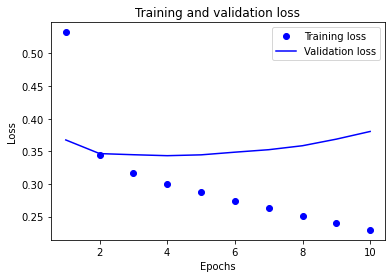

In [18]:
import matplotlib.pyplot as plt

acc1 = history_dict1['accuracy']
val_acc1 = history_dict1['val_accuracy']
loss1 = history_dict1['loss']
val_loss1 = history_dict1['val_loss']

epochs1 = range(1, len(acc1) + 1)

plt.plot(epochs1, loss1, 'bo', label='Training loss') # "파란색 점"
plt.plot(epochs1, val_loss1, 'b', label='Validation loss') # "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

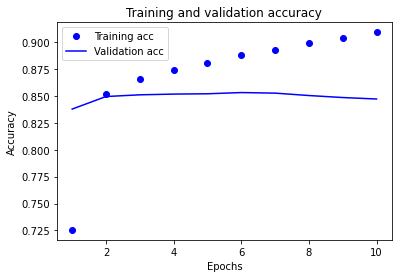

In [19]:
plt.clf()

plt.plot(epochs1, acc1, 'bo', label='Training acc') # "파란색 점"
plt.plot(epochs1, val_acc1, 'b', label='Validation acc') # "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model2

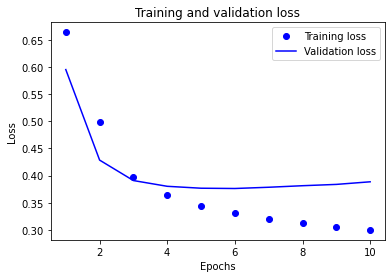

In [20]:
acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']
loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, loss2, 'bo', label='Training loss') # "파란색 점"
plt.plot(epochs2, val_loss2, 'b', label='Validation loss') # "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

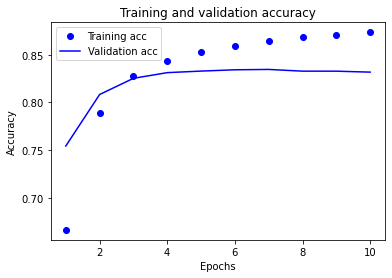

In [21]:
plt.clf()

plt.plot(epochs2, acc2, 'bo', label='Training acc') # "파란색 점"
plt.plot(epochs2, val_acc2, 'b', label='Validation acc') # "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model3

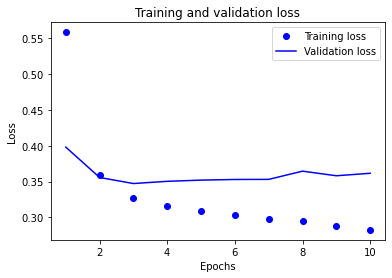

In [22]:
acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs3 = range(1, len(acc3) + 1)

plt.plot(epochs3, loss3, 'bo', label='Training loss') # "파란색 점"
plt.plot(epochs3, val_loss3, 'b', label='Validation loss') # "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

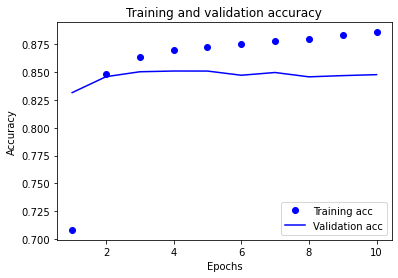

In [23]:
plt.clf()

plt.plot(epochs3, acc3, 'bo', label='Training acc') # "파란색 점"
plt.plot(epochs3, val_acc3, 'b', label='Validation acc') # "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석

가장 좋은 성능을 보이는 model#1,3를 채택하였다.
모델의 성능을 끌어올리기위하여 하이퍼파라미터들을 조절해보았다.
초기에 word_vector_dim = 16으로 설정하였더니 처음부터 validation accuracy가 증가하는 현상을 띄었다. 따라서 word_vector_dim = 4로 조절하여 학습을 진행하였다.
3개의 모델 모두 epoch이 3이후부터는 잘 학습되지 않는 경향을 보였다.

이후로 한국어 Word2Vec을 활용하여 성능개선을 시도해 보았다.

# 한국어 Word2Vec 임베딩 활용하여 성능개선

경로: https://github.com/Kyubyong/wordvectors

In [24]:
import gensim
import os

### 한국어 word2Vec 불러오기

In [25]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

In [26]:
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [27]:
print(word2vec.wv.most_similar("사랑"))

[('슬픔', 0.7216663360595703), ('행복', 0.6759077310562134), ('절망', 0.6468985676765442), ('기쁨', 0.6458414793014526), ('이별', 0.6334798336029053), ('추억', 0.6320937871932983), ('인생', 0.6216273307800293), ('애정', 0.6206068992614746), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


In [28]:
from tensorflow.keras.initializers import Constant

In [29]:
vocab_size = 10000   
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### model생성하기

### Conv1D layer

In [38]:
# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.MaxPooling1D(5))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.GlobalMaxPooling1D())
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

### RNN(LSTM)

In [43]:
# 모델 구성
model5 = keras.Sequential()
model5.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model5.add(keras.layers.LSTM(32))  
model5.add(keras.layers.Dense(8, activation='relu'))
model5.add(keras.layers.Dense(1, activation='sigmoid')) 
model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,030,097
Trainable params: 2,030,097
Non-trainable params: 0
_________________________________________________________________


### model 학습시키기

In [40]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs4=6

history4 = model4.fit(partial_x_train,
                     partial_y_train,
                     epochs=epochs4,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Epoch 1/6
227/227 [==============================] - 7s 30ms/step - loss: 0.5436 - accuracy: 0.7138 - val_loss: 0.4310 - val_accuracy: 0.8027
Epoch 2/6
227/227 [==============================] - 7s 31ms/step - loss: 0.3909 - accuracy: 0.8258 - val_loss: 0.3799 - val_accuracy: 0.8299
Epoch 3/6
227/227 [==============================] - 7s 31ms/step - loss: 0.3321 - accuracy: 0.8582 - val_loss: 0.3533 - val_accuracy: 0.8472
Epoch 4/6
227/227 [==============================] - 7s 31ms/step - loss: 0.2962 - accuracy: 0.8767 - val_loss: 0.3512 - val_accuracy: 0.8489
Epoch 5/6
227/227 [==============================] - 7s 31ms/step - loss: 0.2671 - accuracy: 0.8923 - val_loss: 0.3528 - val_accuracy: 0.8489
Epoch 6/6
227/227 [==============================] - 7s 32ms/step - loss: 0.2448 - accuracy: 0.9028 - val_loss: 0.3609 - val_accuracy: 0.8482


In [41]:
results = model4.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3747 - accuracy: 0.8427
[0.374664306640625, 0.842748761177063]


In [44]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs5=5

history5 = model5.fit(partial_x_train,
                     partial_y_train,
                     epochs=epochs5,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Epoch 1/5
227/227 [==============================] - 18s 81ms/step - loss: 0.4845 - accuracy: 0.7603 - val_loss: 0.3731 - val_accuracy: 0.8351
Epoch 2/5
227/227 [==============================] - 19s 83ms/step - loss: 0.3456 - accuracy: 0.8504 - val_loss: 0.3413 - val_accuracy: 0.8512
Epoch 3/5
227/227 [==============================] - 20s 87ms/step - loss: 0.3039 - accuracy: 0.8724 - val_loss: 0.3335 - val_accuracy: 0.8573
Epoch 4/5
227/227 [==============================] - 20s 87ms/step - loss: 0.2791 - accuracy: 0.8849 - val_loss: 0.3280 - val_accuracy: 0.8593
Epoch 5/5
227/227 [==============================] - 20s 87ms/step - loss: 0.2596 - accuracy: 0.8943 - val_loss: 0.3357 - val_accuracy: 0.8587


In [45]:
results = model5.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3447 - accuracy: 0.8541
[0.344662070274353, 0.8540594577789307]


Word2Vec을 사용하였더니 RNN모델에서의 성능이 많이 상승한 것을 확인할수 있었다.

# 결과 및 총평

여러가지 모델을 사용하여 영화리뷰 데이터를 학습시켜 좋은 리뷰인지 나쁜리뷰인지 판단할 수 있는 판단기를 만들어 보았다.

최종적으로 Word2Vec을 사용하여 85%이상의 정확도를 가진 모델을 얻을 수 있었다.

기회가 된다면 더 많은 하이퍼파라미터들을 수정하여 학습시켜보는 것도 좋은 방안이 될것같다.

언어를 데이터로 학습시킬때 RNN이 아닌 다른 모델로도 학습이 가능하다는 것을 알수 있었고, 이진분류시에는 오히려 더 간단한 모델이 높은 성능을 낼수 있다는 점도 알수 있었다.